# Learns on whole faces, finds face by moving window

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import skimage.transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction import image
from PIL import Image
import threading
import time
import tqdm
# import cv2
from scipy import ndimage

# Classes

In [55]:
class FaceFinder:
    def __init__(self):
        self.img = None
        self.img_not_processed = None
        self.img_orig = None
        self.occurences_map = None
        self.patches = []
        self.preds = None
        self.proba = None

    def process_photo(self, img_name, patch_size=64, stride=1/2):
        self.patches = []
        self.img = plt.imread(img_name)
        self.img_not_processed = self.img.copy()
        self.img = preprocess_image(self.img)
        self.img_orig = self.img.copy()
        self.occurences_map = np.zeros(shape=(self.img.shape[0], self.img.shape[1]))
        
        self._split_pic_into_frames(size=patch_size, stride=stride)
        self._run_predictions()
        
        return self._gray_out()

    def _split_pic_into_frames(self, size, stride):
        sh_x = self.img.shape[1]
        sh_y = self.img.shape[0]
        len_x = size
        len_y = size
        stride_x = np.ceil(len_x*stride).astype(int)
        stride_y = np.ceil(len_y*stride).astype(int)

        for y in range(0, sh_y, stride_y):
            for x in range(0, sh_x, stride_x):
                patch = self.img[y:y+len_y, x:x+len_x]        
                if patch.shape[0]*patch.shape[1]!=0:
                    self.patches.append([patch, (y, x), (y+len_y, x+len_x)])

    def _rectangify_patches(self):
        columns = int(np.sqrt(len(self.preds)))

        cont = True
        while cont:
            cont = False
            for r in range(columns-1):
                for c in range(columns-1):
                    if self.preds[r*columns+c] == 0:
                        LD = self.preds[(r+1)*columns+c-1]
                        SD = self.preds[(r+1)*columns+c]
                        RD = self.preds[(r+1)*columns+c+1]
                        L = self.preds[r*columns+c-1]
                        R = self.preds[r*columns+c+1]
                        LG = self.preds[(r-1)*columns+c-1]
                        SG = self.preds[(r-1)*columns+c]
                        RG = self.preds[(r-1)*columns+c+1]

                        answ = L*LD*SD + SD*RD*R + R*RG*SG + SG*LG*L

                        if answ >= 1:
                            cont = True
                            self.preds[r*columns+c] = 1

    def _gray_out(self):
        coord_start = np.array(self.patches)[:, 1]
        coord_end = np.array(self.patches)[:, 2]

        self.img.setflags(write=1)
        print(f'Patches: {len(self.patches)}')
        for start, end, pred in zip(coord_start, coord_end, self.preds):
            if pred==1:
                self.occurences_map[max(0, start[0]):end[0], max(0, start[1]):end[1]] += 1

        for start, end, pred, proba in zip(coord_start, coord_end, self.preds, self.proba):
            if pred == 1:        
                weight = (proba-1/2)*2
                addition = int(255*weight)/self.occurences_map[max(0, start[0]):end[0], max(0, start[1]):end[1]]            
                added = (self.img_not_processed[max(0, start[0]):end[0], max(0, start[1]):end[1]][:, :, 1].astype(np.float64) + addition)
                added = np.floor(added/255)*255+(1-np.floor(added/255))*added
                self.debug = added

                self.img_not_processed[max(0, start[0]):end[0], max(0, start[1]):end[1]][:, :, 1] = added.astype(np.uint8)

        return self.img, self.img_not_processed

    def _run_predictions(self):
        a = skimage.transform.resize(self.patches[0][0], shape).reshape((1, *shape))
        for i in self.patches[1:]:
            a = np.vstack((a, skimage.transform.resize(i[0], shape).reshape((1, *shape))))
        self.proba = np.array(predict_proba(a, sess))[:, 1]
        self.preds = [round(i) for i in self.proba]

# Model variables

In [61]:
epochs = 5
shape = (64, 64, 1)

## Prepare data

In [51]:
def preprocess_image(img):
#     v = np.median(img)

    # apply automatic Canny edge detection using the computed median
#     lower = int(max(0, (1.0 - 0.33) * v))
#     upper = int(min(255, (1.0 + 0.8) * v))
#     img = cv2.Canny(img, lower, upper)

    R = img[:, :][:, :, 0]
    G = img[:, :][:, :, 1]
    B = img[:, :][:, :, 2]
    img = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
#     img = ndimage.gaussian_filter(img, 3)
#     img = img - lowpass
    return img

In [85]:
def enhance_faces(images):
    res = []
    for i in images:
        res.append(i)
        res.append(skimage.transform.rotate(i, 15))
        res.append(skimage.transform.rotate(i, -15))
          
    return res

In [101]:
def split_pic(img):
#     img = preprocess_image(img)
    face = []
    background = []
    
    img_shape = 256
    
    length = 64 
    stride = 64
    
    for y_coord in range(0, img_shape, stride):
        for x_coord in range(0, img_shape, stride):
            patch = img[y_coord:y_coord+length, x_coord:x_coord+length]
            if y_coord>=64 and y_coord+length<=192 and x_coord>=64 and x_coord+length<=192:
                face.append(patch)
            else:
                background.append(patch)
    face.append(scipy.misc.imresize(img[64:128, 64:128], shape))
    
    return face, background

In [16]:
def readRandomNonFace(not_face_list):
    index = int(np.random.random(1)*len(not_face_list))
    x = plt.imread(not_face_list[index])
    while(len(x.shape) != 3):
        index = int(np.random.random(1)*len(not_face_list))
        x = plt.imread(not_face_list[index])    
    return x

In [120]:
def prepare_data(face_list, not_face_list, resize_size=shape):
    not_faces = []
    
    raw_face = [plt.imread(i) for i in face_list]
#    enhanced_face = enhance_faces(raw_face)       
    processed_faces = [preprocess_image(i) for i in enhanced_face]
    for i in processed_faces:
        _, b = split_pic(i)
        resized = [skimage.transform.resize(img, resize_size) for img in b] 
        [not_faces.append(img) for img in resized]
        
    faces = [skimage.transform.resize(i, resize_size) for i in processed_faces] 
    
    for i in range(len(faces)):
        raw_not_face = readRandomNonFace(not_face_list)
        processed_not_face = preprocess_image(raw_not_face)
        not_face = skimage.transform.resize(raw_not_face, resize_size)
        not_faces.append(not_face)

    y = [[1] for i in range(len(faces))]
    y.extend([[0] for i in range(len(not_faces))])
    print(np.asarray(faces).shape)
    print(np.asarray(not_faces).shape)
    return np.concatenate([faces, not_faces]), y

In [ ]:
with open('Faces/files_list.txt') as f:
    face_files_list = f.readlines()
    
with open('NotFaces/files_list.txt') as f:
    not_face_files_list = f.readlines()
    
face_list = [i.strip() for i in face_files_list] 
not_face_list = [i.strip() for i in not_face_files_list] 

In [121]:
X, y = prepare_data(face_list, not_face_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1);

NameError: name 'enhanced_face' is not defined

In [72]:
img2.shape

(202, 300)

In [ ]:
index = int(np.random.random(1)*len(face_list))
img = plt.imread(face_list[index])
img = preprocess_image(img)

index = int(np.random.random(1)*len(not_face_list))
img2 = plt.imread(not_face_list[index])
img2 = preprocess_image(img2)

index = int(np.random.random(1)*len(X_train))
img3 = X_train[index]

plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(img2, cmap='gray')
plt.subplot(133)
plt.imshow(img3[:, :, 0], cmap='gray')
plt.show()

# Craft and fit model

## Queue-based network

In [22]:
def architecture(inputs):
    inputs = tf.cast(inputs, tf.float32)
    
    # ARCHITECTURE
    with tf.name_scope("convolutional"):
        conv1 = tf.layers.conv2d(
                    inputs=inputs,
                    filters=32,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)

        conv2 = tf.layers.conv2d(
                    inputs=pool1,
                    filters=32,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)

        conv3 = tf.layers.conv2d(
                    inputs=pool2,
                    filters=64,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu)
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides=2)   
        flatten = tf.reshape(pool3, [-1, int((shape[0]/8)*(shape[1]/8)*64)])  

    with tf.name_scope("dense"):
        dense1 = tf.layers.dense(
                    inputs=flatten,
                    units=512)
        dense1_batch = tf.layers.batch_normalization(dense1, training=True)
        dense1_relu = tf.nn.relu(dense1_batch)

        dense2 = tf.layers.dense(
                    inputs=dense1_relu,
                    units=256,
                    activation=tf.nn.relu)

        dense3 = tf.layers.dense(
                    inputs=dense2,
                    units=128)
        dense3_batch = tf.layers.batch_normalization(dense3, training=True)
        dense3_relu = tf.nn.relu(dense3_batch)

        dense4 = tf.layers.dense(
                    inputs=dense3_relu,
                    units=64,
                    activation=tf.nn.relu)

    with tf.name_scope("logits"):
        logits = tf.layers.dense(inputs=dense4, units=2)
    return logits

In [23]:
def predict_proba(X, sess):
    pred_x = tf.convert_to_tensor(X, dtype=np.float32)

    with sess.as_default():
        with tf.variable_scope("output", reuse=True) as scope:
            logits = architecture(pred_x)
            predictions = tf.nn.softmax(logits)
    
        return predictions.eval()

def predict(X, sess):
    result = predict_proba(X, sess)
    return np.argmax(result, axis=1)

In [29]:
def calculate_acc(predictions, y):
    all_true = 0
    true_positives = 0
    false_negatives = 0
    all_positives = 0
    false_positives = 0
    
    for i in range(len(predictions)):
        pos = predictions[i] == 1
        tr = [predictions[i]] == y[i]
        
        if tr:
            all_true += 1          
            if pos:
                true_positives += 1
        if not tr:
            if not pos:
                false_negatives += 1
            if pos:
                false_positives += 1
            
    result = {'acc': 0, 'precision': 0, 'recall': 0, 'sum': all_true, 'all': len(y)}
    result['acc'] = all_true/len(y)
    result['recall'] = true_positives/(true_positives+false_negatives)
    result['precision'] = true_positives/(true_positives + false_positives)
    
    return result

In [25]:
def evaluate(X, y, sess):
    n_iterations = int(np.ceil(len(X) / 64))
    predictions = []
    
    for i in range(n_iterations):
        predictions += predict(X[i*64:(i+1)*64], sess).tolist()
        
    result = calculate_acc(predictions, y)
            
    return result

In [26]:
def fit(X, y, X_test, y_test, epoch_num=5):
    coord = tf.train.Coordinator()
    n_iterations = int(np.ceil(len(X) / 64))
    
    def next_train_batch(X, y):
        batch_x = tf.constant(X, dtype=tf.float32, shape=(len(X), *shape))
        batch_y = tf.constant(y, dtype=tf.int32, shape=[len(X)])

        return [batch_x, batch_y]
    
    with tf.name_scope('train_input'):
        batch_x, batch_y = tf.train.shuffle_batch(
            next_train_batch(X, y),
            enqueue_many=True,
            batch_size=64,
            capacity=10,
            min_after_dequeue=5)
        
    with tf.variable_scope('output'):
        logits = architecture(batch_x)
        probabs = tf.nn.softmax(logits)
        
    with tf.name_scope('train'):
        batch_y = tf.cast(batch_y, tf.int32)
        
        loss = tf.losses.sparse_softmax_cross_entropy(labels=batch_y, logits=logits)
        train_op = tf.train.AdamOptimizer().minimize(loss=loss, global_step=tf.train.get_global_step())
        
    with sess.as_default():
        init = [tf.global_variables_initializer(), tf.local_variables_initializer()]
        sess.run(init)
        
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        
        for epoch in range(epoch_num):
            loss_sum = 0
            preds = []
            labels = []
            for i in tqdm.trange(n_iterations):               
                _, ls, pred, lab = sess.run([train_op, loss, probabs, batch_y])
                loss_sum += ls
                [preds.append(np.argmax(i)) for i in pred]
                [labels.append(i) for i in lab]

            results = calculate_acc(preds, labels)
            print('Training:')
            print('Accuracy: %.3f \t %i/%i' % (results['acc'], results['sum'], len(y)))
            print('Precision: %.3f \t Recall: %.3f' % (results['precision'], results['recall']))
            
            evaluation = evaluate(X_test, y_test, sess)
            print('\nTest:')
            print('Accuracy: %.3f \t %i/%i' % (evaluation['acc'], evaluation['sum'], len(y_test)))
            print('Precision: %.3f \t Recall: %.3f' % (evaluation['precision'], evaluation['recall']))
            
        coord.request_stop()
        coord.join(threads)

In [114]:
print(len(X_train))
print(len(X_test))

16443
1827


In [115]:
tf.reset_default_graph()
sess = tf.Session()
fit(X_train, y_train, X_test, y_test, 3)

100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [02:01<00:00,  2.12it/s]


Training:
Accuracy: 0.954 	 15691/16443
Precision: 0.760 	 Recall: 0.504

Test:
Accuracy: 0.995 	 1818/1827
Precision: 0.955 	 Recall: 0.987


100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [01:38<00:00,  2.62it/s]


Training:
Accuracy: 0.994 	 16351/16443
Precision: 0.962 	 Recall: 0.953

Test:
Accuracy: 0.998 	 1823/1827
Precision: 0.980 	 Recall: 0.993


100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [01:34<00:00,  2.71it/s]


Training:
Accuracy: 0.995 	 16363/16443
Precision: 0.969 	 Recall: 0.957

Test:
Accuracy: 0.998 	 1823/1827
Precision: 1.000 	 Recall: 0.973


## Graph exporting

In [ ]:
# writer = tf.summary.FileWriter('logs', sess.graph)
# print(sess.run(logits, feed_dict={features: [X[0]], labels: [y[0]]}))
# writer.close()

In [ ]:
# predictions = sess.run(ar_max, feed_dict={features: X, labels: y})

# conf = confusion_matrix(y, predictions)
# print(conf)

# Face location

C:\Users\wwydm\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Patches: 294
Patches: 294
Patches: 260
Patches: 330


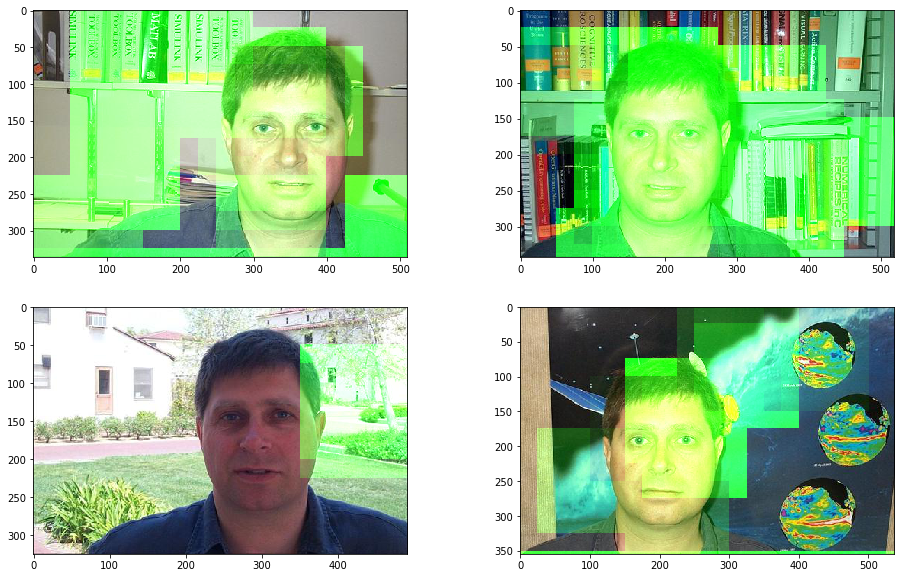

In [119]:
facefinder = FaceFinder()
patch_size = 150
stride = 1/6

img = facefinder.process_photo('Faces_test/image_0001.jpg', patch_size=patch_size, stride=stride)[1]
img1 = facefinder.process_photo('Faces_test/image_0002.jpg', patch_size=patch_size, stride=stride)[1]
img2 = facefinder.process_photo('Faces_test/image_0003.jpg', patch_size=patch_size, stride=stride)[1]
img3 = facefinder.process_photo('Faces_test/image_0004.jpg', patch_size=patch_size, stride=stride)[1]
# img = facefinder.process_photo('George_W_Bush/George_W_Bush_0142.jpg', patch_size=patch_size, stride=stride)[0]
# img1 = facefinder.process_photo('George_W_Bush/George_W_Bush_0141.jpg', patch_size=patch_size, stride=stride)[0]
# img2 = facefinder.process_photo('George_W_Bush/George_W_Bush_0143.jpg', patch_size=patch_size, stride=stride)[0]
# img3 = facefinder.process_photo('George_W_Bush/George_W_Bush_0144.jpg', patch_size=patch_size, stride=stride)[0]

plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.subplot(222)
plt.imshow(img1, cmap='gray')
plt.subplot(223)
plt.imshow(img2, cmap='gray')
plt.subplot(224)
plt.imshow(img3, cmap='gray')
plt.show()

In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
frozen_graph = freeze_session(keras.backend.get_session(), output_names=[model.output.op.name])

In [ ]:
tf.train.write_graph(frozen_graph, "frozen_model", "model.pb", as_text=False)

checkpoint = tf.train.get_checkpoint_state('./frozen/')
input_checkpoint = checkpoint.model_checkpoint_path

absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
output_graph = absolute_model_dir + "/frozen_model.pb"

clear_devices = True

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    saver.restore(sess, input_checkpoint)

    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess,
        tf.get_default_graph().as_graph_def(),
        ['activation_7/Softmax']
    ) 

    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))